In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
)

from sklearn.inspection import PartialDependenceDisplay

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score

In [4]:
from category_encoders import TargetEncoder 
from sklearn.feature_selection import SelectFromModel

In [5]:
from sklearn.datasets import make_classification

In [6]:
TrainPre2019 = pd.read_csv('../data/Train_Pre2019_TimeIntervalLabeled_PerTruck.csv')

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_17866/1553715100.py:1: DtypeWarning: Columns (17,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  TrainPre2019 = pd.read_csv('../data/Train_Pre2019_TimeIntervalLabeled_PerTruck.csv')


In [7]:
TrainPre2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945558 entries, 0 to 945557
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0.1                    945558 non-null  int64  
 1   Unnamed: 0                      945558 non-null  int64  
 2   RecordID                        945558 non-null  int64  
 3   ESS_Id                          945558 non-null  int64  
 4   EventTimeStamp                  945558 non-null  object 
 5   eventDescription                898600 non-null  object 
 6   actionDescription               0 non-null       float64
 7   ecuSoftwareVersion              743930 non-null  object 
 8   ecuSerialNumber                 704649 non-null  object 
 9   ecuModel                        897109 non-null  object 
 10  ecuMake                         897109 non-null  object 
 11  ecuSource                       945558 non-null  int64  
 12  spn             

**Goal:** Predict the rank based on the total shots.

In [8]:
TrainPre2019['time_interval_to_SPN5246_class'].value_counts()

time_interval_to_SPN5246_class
0    943246
2      1546
1       766
Name: count, dtype: int64

In [9]:
TrainPre2019

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class
0,43695,48303,49415,2363162,2015-05-11 13:11:20,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.475814,3276.75,14.4,0.58,639.0_2.0,0,0,301_0,1.027800e+04,0
1,45443,50251,51363,2400445,2015-05-13 08:22:32,Condition Exists Cruise Control Enable Switch,NaN,unknown,unknown,unknown,...,64.637170,3276.75,89.6,4.64,596.0_31.0,0,0,301_0,1.023481e+04,0
2,49998,55260,57330,2482983,2015-05-18 09:34:05,Abnormal Rate of Change Aftertreatment 1 Outle...,NaN,PC4__1284P4C_2*,6U13D13,MX,...,63.525490,3276.75,0.0,20.30,3226.0_10.0,0,0,301_0,1.011362e+04,0
3,54040,59636,61706,2554027,2015-05-21 13:57:35,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.364162,3276.75,12.0,1.45,639.0_2.0,0,0,301_0,1.003723e+04,0
4,54132,59731,61801,2555325,2015-05-21 14:54:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,639.0_2.0,0,0,301_0,1.003628e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945553,3991,4494,4495,1052146,2015-02-24 16:24:05,Low (Severity Medium) Catalyst Tank Level,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,NaN,NaN,NaN,NaN,1761.0_18.0,0,0,R1762_0,2.400000e+08,0
945554,5856,6438,6439,1089561,2015-02-26 13:12:11,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,2.058292,3276.75,0.0,0.29,5848.0_9.0,0,0,R1762_0,2.400000e+08,0
945555,5864,6446,6447,1090499,2015-02-26 13:50:59,NaN,NaN,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,...,NaN,NaN,NaN,NaN,5848.0_9.0,0,0,R1762_0,2.400000e+08,0
945556,4423,4952,4953,1059704,2015-02-25 06:08:43,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,unknown,unknown,unknown,...,4.378725,3276.75,0.0,1.74,639.0_2.0,0,0,R1764_0,2.400000e+08,0



class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [10]:
TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']] = TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class', 'ecuSerialNumber', 'ecuModel', 'ecuMake']].astype('category')

In [11]:
TrainPre2019[['ecuSource', 'LampStatus', ]] = TrainPre2019[['ecuSource', 'LampStatus']].astype('category')

In [12]:
TrainPre2019.replace(to_replace='3276,75', value='3278.75', inplace=True)

In [13]:
TrainPre2019[[  'AcceleratorPedal',
                    'BarometricPressure',
                    'CruiseControlSetSpeed',
                    'DistanceLtd',
                    'EngineCoolantTemperature',
                    'EngineLoad',
                    'EngineOilPressure',
                    'EngineOilTemperature',
                    'EngineRpm',
                    'EngineTimeLtd',
                    'FuelLevel',
                    'FuelLtd',
                    'FuelRate',
                    'FuelTemperature',
                    'IntakeManifoldTemperature',
                    'Speed',
                    'Throttle',
                    'active',
                    'TurboBoostPressure',
                    'activeTransitionCount',
                    'CruiseControlActive',
                    'IgnStatus',
                    'ParkingBrake',
                    'SwitchedBatteryVoltage'
]] = TrainPre2019[[                         'AcceleratorPedal',
                                            'BarometricPressure',
                                            'CruiseControlSetSpeed',
                                            'DistanceLtd',
                                            'EngineCoolantTemperature',
                                            'EngineLoad',
                                            'EngineOilPressure',
                                            'EngineOilTemperature',
                                            'EngineRpm',
                                            'EngineTimeLtd',
                                            'FuelLevel',
                                            'FuelLtd',
                                            'FuelRate',
                                            'FuelTemperature',
                                            'IntakeManifoldTemperature',
                                            'Speed',
                                            'Throttle',
                                            'active',
                                            'TurboBoostPressure',
                                            'activeTransitionCount',
                                            'CruiseControlActive',
                                            'IgnStatus',
                                            'ParkingBrake',
                                            'SwitchedBatteryVoltage'
                     ]].astype('float64')

In [14]:
NumericColumns = TrainPre2019.select_dtypes(include=[np.number]).columns.tolist()
NumericColumns_Without_MatchID = NumericColumns.pop(0)
NumericColumns

['Unnamed: 0',
 'RecordID',
 'ESS_Id',
 'actionDescription',
 'spn',
 'fmi',
 'active',
 'activeTransitionCount',
 'faultValue',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'FaultId',
 'AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlActive',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IgnStatus',
 'IntakeManifoldTemperature',
 'ParkingBrake',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure',
 'is_fullderate',
 'is_fullderate_group',
 'time_to_next_SPN5246']

Among numeric columns, will keep:


['AcceleratorPedal',
'BarometricPressure',
'CruiseControlSetSpeed',
'DistanceLtd',
'EngineCoolantTemperature',
'EngineLoad',
'EngineOilPressure',
'EngineOilTemperature',
'EngineRpm',
'EngineTimeLtd',
'FuelLevel',
'FuelLtd',
'FuelRate',
'FuelTemperature',
'IntakeManifoldTemperature',
'Speed',
'Throttle',
'active',
'TurboBoostPressure',
'activeTransitionCount',
'CruiseControlActive',
'IgnStatus',
'ParkingBrake',
'SwitchedBatteryVoltage']

In [15]:
NonNumericColumns = TrainPre2019.select_dtypes(exclude=[np.number]).columns.tolist()
NonNumericColumns

['EventTimeStamp',
 'eventDescription',
 'ecuSoftwareVersion',
 'ecuSerialNumber',
 'ecuModel',
 'ecuMake',
 'ecuSource',
 'EquipmentID',
 'LocationTimeStamp',
 'LampStatus',
 'spn_fmi',
 'EquipID_Index',
 'time_interval_to_SPN5246_class']

Among, non-numeric columns, will keep:

        ('target_encoder', TargetEncoder(handle_unknown='ignore'), [   'ecuSoftwareVersion',
                                                                        'ecuSerialNumber',
                                                                        'ecuModel',
                                                                        'ecuMake',
                                                                        'spn_fmi'
                                                                    ]),
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), [   'ecuSource',
                                                                                'LampStatus'
                                                                        ])

In [16]:
X = TrainPre2019.drop(columns = [   'Unnamed: 0',
                                    'RecordID',
                                    'ESS_Id',
                                    'actionDescription',
                                    'spn',
                                    'fmi',
                                    'faultValue',
                                    'MCTNumber',
                                    'Latitude',
                                    'Longitude',
                                    'is_fullderate',
                                    'is_fullderate_group',
                                    'time_to_next_SPN5246',
                                    'ServiceDistance',
                                    'EventTimeStamp',
                                    'eventDescription',
                                    'EquipmentID',
                                    'LocationTimeStamp',
                                    'EquipID_Index',
                                    'time_interval_to_SPN5246_class',
                                    'MCTNumber',                                  
                                    'FaultId'                                                                                        
                                ]
                      )
y = TrainPre2019['time_interval_to_SPN5246_class']

In [17]:
X

,Unnamed: 0.1,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,43695,unknown,unknown,unknown,unknown,11,1.0,127.0,14.4,13.9200,...,134.6,1.0,154.4,1279.0,0.0,4.475814,3276.75,14.4,0.58,639.0_2.0
1,45443,unknown,unknown,unknown,unknown,49,1.0,3.0,89.6,14.4275,...,100.4,1.0,120.2,4351.0,0.0,64.637170,3276.75,89.6,4.64,596.0_31.0
2,49998,PC4__1284P4C_2*,6U13D13,MX,PCAR,0,1.0,6.0,0.0,14.3550,...,120.2,1.0,118.4,17407.0,0.0,63.525490,3276.75,0.0,20.30,3226.0_10.0
3,54040,unknown,unknown,unknown,unknown,11,1.0,127.0,12.0,14.5725,...,109.4,1.0,107.6,1279.0,0.0,4.364162,3276.75,12.0,1.45,639.0_2.0
4,54132,unknown,unknown,unknown,unknown,11,0.0,127.0,NaN,NaN,...,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,639.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945553,3991,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,0.0,11.0,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,1761.0_18.0
945554,5856,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,1.0,1.0,0.0,14.2100,...,32.0,1.0,84.2,17407.0,0.0,2.058292,3276.75,0.0,0.29,5848.0_9.0
945555,5864,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,5848.0_9.0
945556,4423,unknown,unknown,unknown,unknown,11,1.0,127.0,21.6,14.4275,...,32.0,1.0,93.2,1279.0,0.0,4.378725,3276.75,0.0,1.74,639.0_2.0


In [18]:
y

0         0
1         0
2         0
3         0
4         0
         ..
945553    0
945554    0
945555    0
945556    0
945557    0
Name: time_interval_to_SPN5246_class, Length: 945558, dtype: category
Categories (3, int64): [0, 1, 2]

In [19]:
X.describe()

,Unnamed: 0.1,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,...,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
count,9.455580e+05,945558.000000,945558.000000,424358.000000,474521.000000,464434.000000,465383.000000,474430.000000,474488.000000,474031.000000,...,473878.000000,473795.000000,247372.000000,491978.000000,474592.000000,302314.000000,472999.000000,102095.000000,319235.000000,472518.000000
mean,4.728048e+05,0.520304,77.225354,28.541964,14.191881,0.097049,62.181007,364649.003943,169.567350,31.972046,...,50561.567985,4.630860,37.023005,0.995723,106.751831,0.284529,26.339840,3104.445477,66.092073,6.289805
std,2.730089e+05,0.499588,59.232122,36.575343,1.194569,0.296025,12.223644,142702.162418,32.833615,30.646621,...,24175.339372,5.787473,23.115581,0.065256,25.486344,0.451190,28.238055,729.771748,46.339979,8.563973
min,0.000000e+00,0.000000,0.000000,0.000000,3.045000,0.000000,0.000000,0.000000,-7.600000,0.000000,...,0.000000,0.000000,17.600000,0.000000,-40.000000,0.000000,0.000000,7.650000,0.000000,0.000000
25%,2.363892e+05,0.000000,1.000000,0.000000,14.210000,0.000000,64.622600,267356.325000,170.600000,11.000000,...,33491.996925,0.647223,32.000000,1.000000,89.600000,0.000000,0.000000,3276.750000,0.000000,0.580000
50%,4.727785e+05,1.000000,126.000000,3.600000,14.355000,0.000000,66.486720,379834.450000,183.200000,19.000000,...,51943.886413,1.690706,32.000000,1.000000,109.400000,0.000000,9.679798,3276.750000,100.000000,2.030000
75%,7.091678e+05,1.000000,126.000000,48.800000,14.500000,0.000000,66.486720,481544.600000,186.800000,48.000000,...,68751.172791,7.211920,32.000000,1.000000,125.600000,1.000000,60.018145,3276.750000,100.000000,8.700000
max,1.053228e+06,1.000000,127.000000,100.000000,15.225000,1.000000,69.593570,649549.000000,406.400000,101.000000,...,312737.574126,25.611560,231.800000,1.000000,264.200000,1.000000,158.447200,3278.750000,100.000000,63.220000


In [20]:
X

le_y = LabelEncoder()

y_fitted = le_y.fit(y)
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 321, shuffle=True, stratify = y_encoded)


In [26]:
# scaler = StandardScaler()


ct = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [  'AcceleratorPedal',
                                        'BarometricPressure',
                                        'CruiseControlSetSpeed',
                                        'DistanceLtd',
                                        'EngineCoolantTemperature',
                                        'EngineLoad',
                                        'EngineOilPressure',
                                        'EngineOilTemperature',
                                        'EngineRpm',
                                        'EngineTimeLtd',
                                        'FuelLevel',
                                        'FuelLtd',
                                        'FuelRate',
                                        'FuelTemperature',
                                        'IntakeManifoldTemperature',
                                        'Speed',
                                        'Throttle',
                                        'active',
                                        'TurboBoostPressure',
                                        'activeTransitionCount',
                                        'CruiseControlActive',
                                        'IgnStatus',
                                        'ParkingBrake',
                                        'SwitchedBatteryVoltage'
                                        ]),
        ('target_encoder', TargetEncoder(handle_unknown='ignore'), [  'ecuSoftwareVersion',
                                                                       'ecuSerialNumber',
                                                                       'ecuModel',
                                                                       'ecuMake',
                                                                        'spn_fmi',
                                                                        'ecuSource',
                                                                        'LampStatus'
                                                                    ]) #,
      # ('ordinal_encoder', OrdinalEncoder(handle_unknown='ignore'), [   'ecuSource',
       #                                                                         'LampStatus'
        #                                                                ])
    ],
    remainder='passthrough'
)

xgbc_pipe = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('xgbc', XGBClassifier( enable_categorical=True, 
                               # max_cat_to_onehot=1,
                                booster='gbtree', 
                                eval_metric='mlogloss',
                                objective = 'multi:softprob'
                            )
        )
    ]
).fit(X_train, y_train) 

y_pred = xgbc_pipe.predict(X_test)  





('xgbc', XGBClassifier(learning_rate = 0.05,
                    colsample_bytree = 0.8,
                    gamma = 0.1,
                    max_depth = 5,
                    min_child_weight = 1,
                    reg_alpha = 0.01,
                    n_estimators = 199,
                    subsample = 0.6,
                    eval_metric='mlogloss'
                            )

        ('xgbc', XGBClassifier(learning_rate = 0.05,
                    colsample_bytree = 0.8,
                    gamma = 0.1,
                    max_depth = 4,
                    min_child_weight = 3,
                    reg_alpha = 0.01,
                    n_estimators = 190,
                    subsample = 0.6,
                    eval_metric='mlogloss'
                            )

In [27]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 0.004336054824654173
RMSE: 0.06584872682637206
MAE: 0.00252760269046914
MAPE: 2167115603931.613
R2: 0.4083082208807012


xgb = XGBClassifier(
                    eval_metric='mlogloss'
                    
                    ).fit(X_train, y_train)

In [ ]:
le_y

LabelEncoder()

In [ ]:
y_fitted

LabelEncoder()

In [ ]:
y_encoded

array([0, 0, 0, ..., 0, 0, 0], shape=(945558,))

In [ ]:
y

0         0
1         0
2         0
3         0
4         0
         ..
945553    0
945554    0
945555    0
945556    0
945557    0
Name: time_interval_to_SPN5246_class, Length: 945558, dtype: category
Categories (3, int64): [0, 1, 2]

SyntaxError: invalid syntax (4067800170.py, line 1)


#RandomizedSearchCV

param_dist = {
    'max_depth': range(1, 10, 1),
    'min_child_weight':range(1, 6, 1),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample':[i/10.0 for i in range(1, 10)],
    'colsample_bytree':[i/10.0 for i in range(1, 10)],
    'n_estimators':stats.randint(1, 70),
    'gamma':[i/10.0 for i in range(0, 5)],
   # 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
    
}



# xgb_model = XGBClassifier()

# Create the RandomizedSearchCV object
cv = RepeatedStratifiedKFold(n_splits=10, shuffle=True, random_state=343)
random_search = RandomizedSearchCV(xgbc_pipe[1], param_distributions=param_dist, n_iter=20, cv=cv, scoring='precision_macro', verbose=2, n_jobs=-1, random_state=321)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)






In [28]:
accuracy_score(y_test, y_pred)

0.9983766233766234

In [29]:
confusion_matrix(y_test, y_pred)

array([[188600,      9,     41],
       [   103,     29,     21],
       [   130,      3,    176]])

In [30]:
print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    188650
           1       0.71      0.19      0.30       153
           2       0.74      0.57      0.64       309

    accuracy                           1.00    189112
   macro avg       0.82      0.59      0.65    189112
weighted avg       1.00      1.00      1.00    189112



In [31]:
scores = cross_val_score(xgbc_pipe, X_test, y_test, cv=10, scoring='precision_macro')

In [32]:
print('Cross Validation Accuracy Scores:', scores)

Cross Validation Accuracy Scores: [0.70890744 0.72167525 0.61687938 0.47769611 0.62814757 0.63992294
 0.58006126 0.61058162 0.69644023 0.88839477]


### Top Features' Importance

In [33]:
selection = SelectFromModel(xgbc_pipe[1], threshold=0.01, prefit=True)

In [34]:
X_selected = selection.transform(X_train)
X_selected

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[182391, 'unknown', 'unknown', ..., nan, nan, '111.0_17.0'],
       [417356, nan, '5N39150139', ..., nan, nan, '1056.0_2.0'],
       [925776, nan, '5W26150421', ..., nan, nan, '934.0_4.0'],
       ...,
       [442595, '05317106*05031149*050815201656*09400035*G1*BDR*',
        '79857689', ..., nan, nan, '111.0_17.0'],
       [723091, nan, nan, ..., 100.0, 15.37, '96.0_3.0'],
       [645361, nan, nan, ..., 0.0, 7.54, '929.0_9.0']],
      shape=(756446, 32), dtype=object)

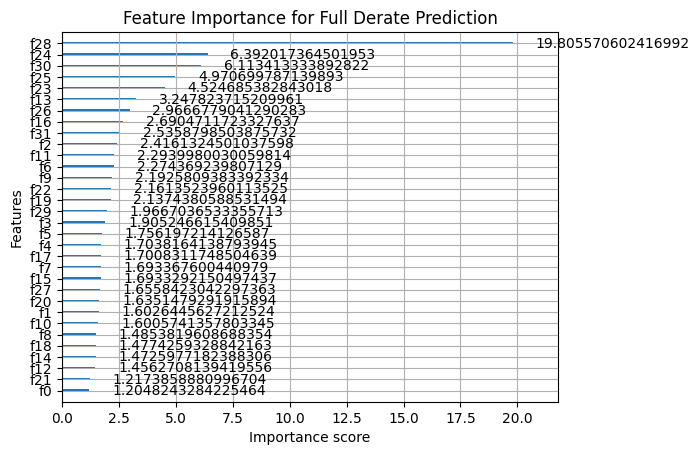

In [35]:
plot_importance_object = plot_importance(xgbc_pipe[1], importance_type='gain')
plt.title('Feature Importance for Full Derate Prediction')
plt.show()

In [36]:
feature_importances = xgbc_pipe[1].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_30_features = feature_importance_df.head(30)

print(top_30_features)

                      Feature  Importance
28     SwitchedBatteryVoltage    0.210808
24  IntakeManifoldTemperature    0.068036
30         TurboBoostPressure    0.065070
25                 LampStatus    0.052908
23                  IgnStatus    0.048160
13   EngineCoolantTemperature    0.034569
26               ParkingBrake    0.031577
16       EngineOilTemperature    0.028637
31                    spn_fmi    0.026992
2             ecuSerialNumber    0.025717
11      CruiseControlSetSpeed    0.024417
6                      active    0.024208
9          BarometricPressure    0.023338
22            FuelTemperature    0.023005
19                  FuelLevel    0.022751
29                   Throttle    0.020933
3                    ecuModel    0.020279
5                   ecuSource    0.018693
4                     ecuMake    0.018135
17                  EngineRpm    0.018103
7       activeTransitionCount    0.018024
15          EngineOilPressure    0.018024
27                      Speed    0

In [37]:
print("Top 30 features:", top_30_features['Feature'].tolist())

Top 30 features: ['SwitchedBatteryVoltage', 'IntakeManifoldTemperature', 'TurboBoostPressure', 'LampStatus', 'IgnStatus', 'EngineCoolantTemperature', 'ParkingBrake', 'EngineOilTemperature', 'spn_fmi', 'ecuSerialNumber', 'CruiseControlSetSpeed', 'active', 'BarometricPressure', 'FuelTemperature', 'FuelLevel', 'Throttle', 'ecuModel', 'ecuSource', 'ecuMake', 'EngineRpm', 'activeTransitionCount', 'EngineOilPressure', 'Speed', 'FuelLtd', 'ecuSoftwareVersion', 'CruiseControlActive', 'AcceleratorPedal', 'EngineTimeLtd', 'EngineLoad', 'DistanceLtd']


### Import fresh test data (previously held out) for a fresh round of testing 

In [38]:
test = pd.read_csv('../data/Test_In2019_TimeIntervalLabeled_PerTruck.csv')

In [39]:
FreshTest_In2019 = test
FreshTest_In2019

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class
0,948793,1062090,1104925,73930906,2019-01-11 12:51:18,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,96.0_3.0,0,1,301_1,239999976.0,0
1,948794,1062091,1104926,73930907,2019-01-11 12:51:18,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,829.0_3.0,0,1,301_1,239999976.0,0
2,948799,1062096,1104931,73934247,2019-01-11 13:11:40,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,96.0_3.0,0,1,301_1,239999976.0,0
3,948800,1062097,1104932,73934248,2019-01-11 13:11:40,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,829.0_3.0,0,1,301_1,239999976.0,0
4,948826,1062135,1104970,73942005,2019-01-11 13:13:38,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,0.00000,NaN,0.0,1.16,96.0_3.0,0,1,301_1,239999976.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111707,973069,1089938,1137548,80503703,2019-03-16 11:22:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,...,NaN,NaN,NaN,NaN,639.0_2.0,0,0,105437340_0,239999976.0,0
111708,973093,1089962,1137572,80509396,2019-03-16 11:24:04,Special Instructions Engine Starter Solenoid L...,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,1321.0_14.0,0,0,105437340_0,239999976.0,0
111709,973094,1089963,1137573,80509397,2019-03-16 11:27:41,NaN,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,520321.0_13.0,0,0,105437340_0,239999976.0,0
111710,974430,1091502,1139112,80907838,2019-03-20 10:57:34,Special Instructions Engine Starter Solenoid L...,NaN,NaN,K1243673,FAOM-xx810S-EC3,...,NaN,NaN,NaN,NaN,1321.0_14.0,0,0,105437340_0,239999976.0,0


In [40]:
FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class']] = FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class']].astype('str')

In [41]:
X_fresh_test = FreshTest_In2019.drop(columns = [    'Unnamed: 0',
                                                    'RecordID',
                                                    'ESS_Id',
                                                    'actionDescription',
                                                    'spn',
                                                    'fmi',
                                                    'faultValue',
                                                    'MCTNumber',
                                                    'Latitude',
                                                    'Longitude',
                                                    'is_fullderate',
                                                    'is_fullderate_group',
                                                    'time_to_next_SPN5246',
                                                    'ServiceDistance',
                                                    'EventTimeStamp',
                                                    'eventDescription',
                                                    'EquipmentID',
                                                    'LocationTimeStamp',
                                                    'EquipID_Index',
                                                    'time_interval_to_SPN5246_class',
                                                    'MCTNumber',                                  
                                                    'FaultId'                                                        
                                                ]
                                     )  
X_fresh_test

,Unnamed: 0.1,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,active,activeTransitionCount,AcceleratorPedal,BarometricPressure,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,948793,unknown,unknown,unknown,unknown,49,True,126,34.0,14.5,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,96.0_3.0
1,948794,unknown,unknown,unknown,unknown,49,True,126,34.0,14.5,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,829.0_3.0
2,948799,unknown,unknown,unknown,unknown,49,False,126,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,96.0_3.0
3,948800,unknown,unknown,unknown,unknown,49,False,126,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,829.0_3.0
4,948826,unknown,unknown,unknown,unknown,49,True,126,0.0,14.5,...,87.8,True,107.6,1279.0,True,0.00000,NaN,0.0,1.16,96.0_3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111707,973069,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,BNDWS,11,False,127,NaN,NaN,...,NaN,NaN,NaN,50175.0,NaN,NaN,NaN,NaN,NaN,639.0_2.0
111708,973093,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,EATON,3,True,1,0.0,14.5,...,NaN,True,68.0,63487.0,True,0.00000,NaN,100.0,0.29,1321.0_14.0
111709,973094,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,EATON,3,True,4,0.0,14.5,...,NaN,True,73.4,63487.0,True,0.00000,NaN,100.0,0.29,520321.0_13.0
111710,974430,NaN,K1243673,FAOM-xx810S-EC3,EATON,3,False,5,NaN,NaN,...,NaN,NaN,NaN,63487.0,NaN,NaN,NaN,NaN,NaN,1321.0_14.0


In [42]:
X_fresh_test.shape

(111712, 32)

X_FreshTest_Transformed = ct.transform(X_fresh_test)
X_FreshTest_Transformed

In [43]:
y_fresh_pred = xgbc_pipe.predict(X_fresh_test)

In [44]:
y_fresh_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(111712,))

In [45]:
y_fresh_test = FreshTest_In2019['time_interval_to_SPN5246_class']

In [46]:
y_fresh_test_encoded = le_y.transform(y_fresh_test)

In [47]:
accuracy_score(y_fresh_test_encoded, y_fresh_pred)

0.9877542251503867

In [48]:
confusion_matrix(y_fresh_test_encoded, y_fresh_pred)

array([[110315,      3,   1076],
       [   141,      0,     14],
       [   134,      0,     29]])

In [49]:
print(classification_report(y_fresh_test_encoded, y_fresh_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    111394
           1       0.00      0.00      0.00       155
           2       0.03      0.18      0.05       163

    accuracy                           0.99    111712
   macro avg       0.34      0.39      0.35    111712
weighted avg       0.99      0.99      0.99    111712



In [50]:
print(f'MSE: {mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'RMSE: {root_mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAE: {mean_absolute_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'R2: {r2_score(y_fresh_test_encoded, y_fresh_pred)}')

MSE: 0.04474004583213979
RMSE: 0.2115184290603062
MAE: 0.023077198510455456
MAPE: 86877481353690.02
R2: -5.209243675919267


In [51]:
fresh_CV_scores = cross_val_score(xgbc_pipe, X_fresh_test, y_fresh_test_encoded, cv=10, scoring='precision_macro')

In [52]:
print('Cross Validation Accuracy Scores:', fresh_CV_scores)

Cross Validation Accuracy Scores: [0.33820684 0.3437605  0.35651069 0.45468937 0.34392096 0.34197963
 0.37337755 0.39182955 0.43294765 0.54086036]


In [53]:
# submission.to_csv('../data/submission_XGBClassifier_TunedHyperparameter_TargetEncoder_LearningRatePt05_MaxTreeDepth5_MinChild1_Estimators199_TestSizePt001_MostFeatures_ExcludingMapCode.csv', index = False)